In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import os
import random
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_auc_score
random.seed(4)

In [2]:
class DMBI_hackathon_ddi_utils():
    NODE_1 = 'node1'
    NODE_2 = 'node2'
    def __init__(self,number_of_drugs = 1434):
        self.number_of_drugs =number_of_drugs

    def write_list_to_file(self, list, path):
        thefile = open(path, 'w')
        for item in list:
            thefile.write("%s\n" % item)
        thefile.close()

    def read_sparse_matrix(self,train_data):
        print('creating matrix')
        x = train_data[self.NODE_1]
        y = train_data[self.NODE_2]
        assert len(x) == len(y)
        data = [1] * len(x)
        m = csr_matrix((data,(x,y)), shape=(self.number_of_drugs, self.number_of_drugs),dtype='f')
        print('m shape:', m.shape, 'm non zeros:', m.nnz)
        assert np.allclose(m.todense(), m.T.todense(), atol=1e-8) #matrix is symmetric
        return m.todense()#the matrix is small, sparse matrix is not necessary.
    
    def write_solution_to_file(self,preds,file_path, num_interactions_train):
        #preds is assumed to be ordered by confidence level
        #adds the header to the soution, combines the node IDs and writes the soךution to file
        #asserts are important. Note them.
        
        print(f'writing predictions to file: {file_path}')
        for u, v in preds:
           assert u < v, 'graph is undirected, predict edges where the first node id is smaller than the second only'
        assert len(preds) == (self.number_of_drugs * self.number_of_drugs - self.number_of_drugs - num_interactions_train) / 2, "number of predictions is equal to number of non existing edges"
        output = [','.join([self.NODE_1 + '_' + self.NODE_2])]+[','.join([str(p[0]) +'_' + str(p[1])]) for p in preds]
        self.write_list_to_file(output,file_path)

    def create_holdout_set(self,m_train,train_percent = 0.9):
        #create holdout set. the set will contains both existing and non-existing edges.
        m_train_holdout = np.matrix(m_train)
        validation_set = set()
        for i in range(self.number_of_drugs):
            for j in range(i+1,self.number_of_drugs):
                if random.random()>train_percent:
                    validation_set.add((i,j))
                    m_train_holdout[i,j] = 0
                    m_train_holdout[j, i] = 0
        return m_train_holdout,validation_set

    def average_precision_at_k(self,k, class_correct):
        #return average precision at k.
        #more examples: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
        #and: https://www.kaggle.com/c/avito-prohibited-content#evaluation
        #class_correct is a list with the binary correct label ordered by confidence level.
        assert k <= len(class_correct) and k > 0        
        score = 0.0
        hits = 0.0
        for i in range(k):
            if class_correct[i]==1:
                hits += 1.0
            score += hits /(i+1.0)
        score /= k
        return score



In [3]:
#simple prediction class
class link_prediction_predictor:
    def __init__(self,number_of_drugs):
        self.G = nx.Graph()
        self.G.add_nodes_from(range(number_of_drugs))

    def fit(self,edge_list):
        self.G.add_edges_from(edge_list)

    def predict(self,prediction_set=None):
        preds = nx.resource_allocation_index(self.G,ebunch=prediction_set)  
        # if ebunch is None then all non-existent edges in the graph will be used.
        preds = [(u1, v1) for (p, u1, v1) in sorted([(prediction, u, v) for (u, v, prediction) in preds],reverse=True)]  
        #predictions are expected as described in write_solution_to_file. The values are suppose to be ordered by confidence.
        return preds

In [4]:
DMBI_hackathon_ddi = DMBI_hackathon_ddi_utils()
train_matrix = DMBI_hackathon_ddi.read_sparse_matrix(pd.read_csv('train.csv'))


creating matrix
m shape: (1434, 1434) m non zeros: 93200


In [13]:
train_matrix[71,407]

1.0

In [7]:
### full graph
m_train_holdout,validation_set = DMBI_hackathon_ddi.create_holdout_set(train_matrix,train_percent=1)
x,y = m_train_holdout.nonzero() #x and y indeices of nonzero cells (existing edges)
edge_list = list(zip(x,y)) 
link_prediction = link_prediction_predictor(DMBI_hackathon_ddi.number_of_drugs)
link_prediction.fit(edge_list)

In [15]:
n = [i for i in range(0,1433) if i not in [71,407]]
n

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,

In [17]:
G = link_prediction.G
G = G.subgraph(n)

In [13]:
#Evaluate model. 
#Note that holdout is based on random decision. 
m_train_holdout,validation_set = DMBI_hackathon_ddi.create_holdout_set(train_matrix)
x,y = m_train_holdout.nonzero() #x and y indeices of nonzero cells (existing edges)
edge_list = list(zip(x,y)) 
link_prediction = link_prediction_predictor(DMBI_hackathon_ddi.number_of_drugs)
link_prediction.fit(edge_list)

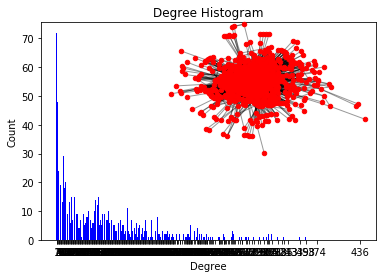

In [18]:
import collections
#G = link_prediction.G
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()

In [ ]:
def hist_generator(name,seq):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    count = collections.Counter(seq)
    deg, cnt = zip(*count.items())
    
    plt.figure(figsize=(10,9))
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title(name + " Histogram")
    plt.ylabel("Count")
    plt.xlabel(name)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

# node based features

In [20]:
from networkx.algorithms import centrality, link_analysis

df_nodes = pd.DataFrame(index=G.nodes())
df_nodes['clustering'] = pd.Series(nx.clustering(G))
df_nodes['degree'] = pd.Series(dict(G.degree()))
df_nodes['degree_centrality'] =  pd.Series(centrality.degree_centrality(G))
df_nodes['closeness_centrality'] =  pd.Series(centrality.closeness_centrality(G))
df_nodes['betweenness_centrality'] =  pd.Series(centrality.betweenness_centrality(G))
df_nodes['pagerank'] = pd.Series(link_analysis.pagerank(G))
df_nodes.to_csv('nodes.csv')

In [31]:
page_rank = pd.Series(link_analysis.pagerank(G))
page_rank.head()

0    0.000340
1    0.000573
2    0.002014
3    0.000406
4    0.000793
dtype: float64

# Edge based features


In [ ]:
pairs = nx.to_pandas_edgelist(G)
pairs.columns = ['node1','node2']
pairs['is_edge'] = 1
un_pairs = nx.to_pandas_edgelist(nx.Graph(nx.non_edges(G)))
un_pairs.columns = ['node1','node2']
un_pairs['is_edge'] = 0
total_edges = pd.concat([pairs,un_pairs],axis=0)
total_edges = total_edges.sort_values(by=['node1','node2'])
total_edges['jaccard_coefficient'] = pd.DataFrame(nx.jaccard_coefficient(G))[2]
total_edges['adamic_adar_index'] = pd.DataFrame(nx.adamic_adar_index(G))[2]
total_edges['resource_allocation_index'] = pd.DataFrame(nx.resource_allocation_index(G))[2]
total_edges['preferential_attachment'] = pd.DataFrame(nx.preferential_attachment(G))[2]
total_edges['shortest_path_length'] = [-1 if not (int(row['node1']) in sh.keys() and int(row['node2']) in sh[int(row['node1'])].keys()) else sh[int(row['node1'])][int(row['node2'])] for i,row in total_edges.iterrows()]
total_edges.to_csv('edges.csv')

In [64]:
sh = dict(nx.all_pairs_shortest_path_length(G))

In [86]:
sh[0][1]

3

In [87]:
total_edges['shortest_path_length'] = [-1 if not (int(row['node1']) in sh.keys() and int(row['node2']) in sh[int(row['node1'])].keys()) else sh[int(row['node1'])][int(row['node2'])] for i,row in total_edges.iterrows()]

In [89]:
total_edges.to_csv('edges.csv')

In [92]:
total_edges.head()


,node1,node2,is_edge,jaccard_coefficient,adamic_adar_index,resource_allocation_index,preferential_attachment,shortest_path_length
0,0,1,0,0.0,0.0,0.0,736,3
1,0,2,0,0.0,0.0,0.0,2976,3
2,0,3,0,0.0,0.0,0.0,176,3
3,0,4,0,0.0,0.0,0.0,1120,3
4,0,5,0,0.0,0.0,0.0,48,3


In [5]:
#Test set contains new interactions that random selection does not emulate.
preds = link_prediction.predict(validation_set)
class_correct = [train_matrix[x[0],x[1]] for x in preds]
average_precision = DMBI_hackathon_ddi.average_precision_at_k(k=100,class_correct=class_correct)
print(f'average precision @ 100: {average_precision}')

average precision @ 100: 0.4512662265189656


In [6]:
#Create final submission file
x,y = train_matrix.nonzero()
num_interactions_train = len(x);assert len(x)==len(y)
edge_list = list(zip(x,y))
link_prediction = link_prediction_predictor(DMBI_hackathon_ddi.number_of_drugs)
link_prediction.fit(edge_list)
preds = link_prediction.predict()
DMBI_hackathon_ddi.write_solution_to_file(preds,'sample_predictions.csv',num_interactions_train=num_interactions_train)

writing predictions to file: sample_predictions.csv
